In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import keras
import keras.preprocessing.image
from keras_retinanet.models.resnet import custom_objects
from keras_retinanet.preprocessing.csv_generator import CSVGenerator

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
keras.backend.tensorflow_backend.set_session(get_session())

Using TensorFlow backend.


In [2]:
model = keras.models.load_model('../snapshots/resnet50_csv_01.h5', custom_objects=custom_objects)
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
padding_conv1 (ZeroPadding2D)   (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9408        padding_conv1[0][0]              
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu

c:\programdata\anaconda3\lib\site-packages\keras-2.1.2-py3.6.egg\keras\models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [3]:
# create image data generator object
val_image_data_generator = keras.preprocessing.image.ImageDataGenerator()

# create a generator for testing data
validation_generator = CSVGenerator(
                'C:\\Users\\Kai\\study\\robot_prototype\\data\\MLRotation\\annotation2.txt',
                'C:\\Users\\Kai\\study\\robot_prototype\\data\\MLRotation\\classname2.txt',
                val_image_data_generator,
                batch_size=1000
            )
index = 10000

10001
C:\Users\Kai\study\robot_prototype\data\MLRotation\resultImg/out_0_130_-5.png
1.0033444816053512
[[ 436.  206.  536.  306.    4.]]


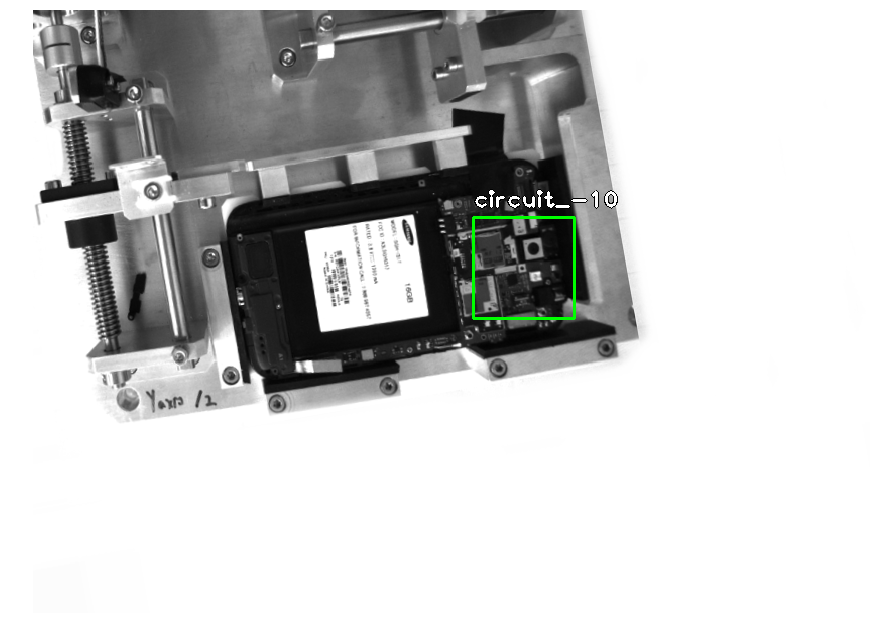

In [4]:
# load image
image = validation_generator.load_image(index)

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = validation_generator.preprocess_image(image)
image, scale = validation_generator.resize_image(image)
annotations = validation_generator.load_annotations(index)
index += 1

print(index)
print(validation_generator.image_path(index))
print(scale)
print(annotations)

# visualize annotations
for annotation in annotations:
    label = int(annotation[4])
    b = annotation[:4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 255, 0), 2)
    caption = "{}".format(validation_generator.label_to_name(label))
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

In [5]:
# process image
start = time.time()
_, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# compute predicted labels and scores
predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]

# correct for image scale
detections[0, :, :4] /= scale

processing time:  16.28448247909546


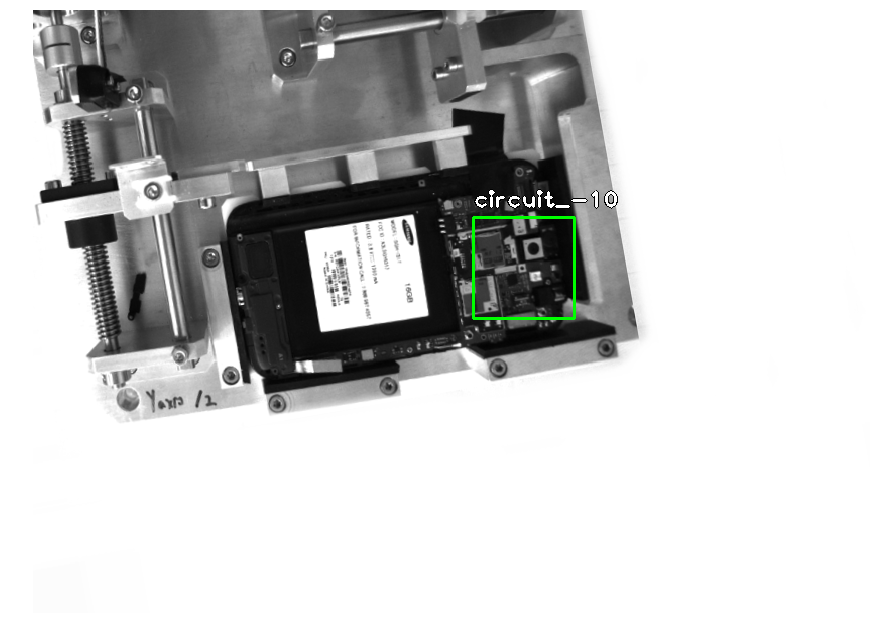

In [6]:
# visualize detections
for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
    if score < 0.5:
        continue
    b = detections[0, idx, :4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 3)
    caption = "{} {:.3f}".format(validation_generator.label_to_name(label), score)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
    
# visualize annotations
for annotation in annotations:
    label = int(annotation[4])
    b = annotation[:4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 255, 0), 2)
    caption = "{}".format(validation_generator.label_to_name(label))
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

In [7]:
print(detections)

[[[ -8.50773697e+01   4.88626892e+02   1.16787857e+02 ...,   9.96324979e-03
     9.97229293e-03   9.97451600e-03]
  [ -4.26022263e+01   5.47200256e+02   5.84398613e+01 ...,   9.95703787e-03
     9.96804330e-03   9.97086801e-03]
  [  7.86574829e+02   5.47175293e+02   8.87830444e+02 ...,   9.94895119e-03
     9.96344630e-03   9.96723957e-03]
  ..., 
  [  8.13084900e+02   2.94731018e+02   8.53207336e+02 ...,   9.74135194e-03
     9.78675392e-03   9.79780499e-03]
  [  7.89813843e+02   4.86834747e+02   8.52430420e+02 ...,   9.78361722e-03
     9.79904458e-03   9.79669485e-03]
  [  1.48727203e+02   4.03470856e+02   2.50164246e+02 ...,   9.69389919e-03
     9.77792777e-03   9.80052073e-03]]]


In [8]:
print(scores)

[ 0.00997539  0.00997143  0.00996835  0.00996443  0.00996333  0.00996207
  0.00996163  0.00995791  0.00995647  0.00995386  0.00995305  0.0099527
  0.00995173  0.00994846  0.00994641  0.00994122  0.00994082  0.00994015
  0.00993909  0.00993846  0.00993607  0.00993597  0.00993534  0.00993473
  0.0099345   0.00993255  0.00993246  0.00993131  0.00993027  0.0099296
  0.00992902  0.00992772  0.00992679  0.00992664  0.00992617  0.00992602
  0.00992546  0.00992538  0.00992521  0.00992521  0.00992501  0.00992466
  0.00992414  0.00992301  0.00992294  0.00992238  0.00992068  0.00991979
  0.00991901  0.00991867  0.00991766  0.00991399  0.00991395  0.0099137
  0.00991224  0.00990969  0.00990881  0.00990881  0.00990877  0.00990864
  0.00990834  0.00990819  0.00990813  0.00990767  0.00990737  0.0099072
  0.00990702  0.00990701  0.00990587  0.00990567  0.00990494  0.00990455
  0.00990452  0.00990426  0.00990371  0.00990355  0.00990281  0.00990264
  0.00990261  0.0099025   0.00990197  0.00990044  0.009